In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from os.path import basename, dirname

In [2]:
# Set `res_d`
base = "/data/sls/temp/johnmwu/contextual-corr-analysis/results1_"
res_fname = {method : base + method for method in 
                {"maxcorr", "mincorr", "linreg", "svcca", "cka"}}

res_d = {}
res_d["maxcorr"] = json.load(open(res_fname["maxcorr"], "r"))
res_d["mincorr"] = json.load(open(res_fname["mincorr"], "r"))
res_d["linreg"] = json.load(open(res_fname["linreg"], "r"))

network_l = [network for network in res_d["maxcorr"]]

In [3]:
# Set `network_l`, `num_neurons_d`
num_neurons_d = {}
for network in network_l:
    num_neurons_d[network] = len(res_d["maxcorr"][network])

num_neurons_d

{'/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_large_cased/ptb_pos_dev.hdf5': 1024,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/openai_transformer/ptb_pos_dev.hdf5': 768,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_base_cased/ptb_pos_dev.hdf5': 768,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/elmo_original/ptb_pos_dev.hdf5': 1024,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/calypso_transformer_6_512_base/ptb_pos_dev.hdf5': 1024,
 '/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/elmo_4x4096_512/ptb_pos_dev.hdf5': 1024}

# Sorts

In [4]:
rk_methods = {"maxcorr", "mincorr", "linreg"}

In [5]:
neuron_sorts = {network: {} for network in network_l}
for network in network_l:
    for method in rk_methods:
        neuron_sorts[network][method] = [neuron[0] for neuron in res_d[method][network]]

In [6]:
# helper
# network = network_l[0]

# method = "maxcorr"
# ranks = [neuron_sorts[network][method].index(i) for i in range(len(neuron_sorts[network][method]))]
# ranks

# rk_ar = np.stack([
#             [neuron_sorts[network][method].index(i) for i in range(len(neuron_sorts[network][method]))]
#                       for method in rk_methods
# ])

# rk_ar

In [7]:
# Set `rk_ar_d`, `rk_df_d`, `spearman_d`
rk_ar_d = {}
rk_df_d = {}
spearman_d = {}
for network in network_l:
    # rk_ar[method_ix, neuron] = rank
    # need to invert the permutation
    rk_ar = np.stack([
            [neuron_sorts[network][method].index(neuron) for neuron in range(len(neuron_sorts[network][method]))]
                      for method in rk_methods
    ]).T
    rk_df = pd.DataFrame(rk_ar, columns=list(rk_methods))
    
    rk_ar_d[network] = rk_ar
    rk_df_d[network] = rk_df
    spearman_d[network] = rk_df.corr()

In [8]:
for network in network_l:
    print(network)
    print(rk_ar_d[network])
    print(spearman_d[network])

/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_large_cased/ptb_pos_dev.hdf5
[[799 706 644]
 [ 35  48  32]
 [436 589 429]
 ...
 [508 325 475]
 [904 912 845]
 [815 869 799]]
           linreg   maxcorr   mincorr
linreg   1.000000  0.822364  0.825473
maxcorr  0.822364  1.000000  0.833914
mincorr  0.825473  0.833914  1.000000
/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/openai_transformer/ptb_pos_dev.hdf5
[[ 54  62  54]
 [728 553 645]
 [159  80  67]
 ...
 [745 695 704]
 [757 760 722]
 [358 302 287]]
           linreg   maxcorr   mincorr
linreg   1.000000  0.807733  0.793264
maxcorr  0.807733  1.000000  0.763334
mincorr  0.793264  0.763334  1.000000
/data/sls/temp/belinkov/contextual-corr-analysis/contextualizers/bert_base_cased/ptb_pos_dev.hdf5
[[579 344 510]
 [196 341 376]
 [383 409 571]
 ...
 [689 350 649]
 [151 380 215]
 [272 148  56]]
           linreg   maxcorr   mincorr
linreg   1.000000  0.769092  0.777040
maxcorr  0.769092  1.000000  0.756

# Distributions
Currently only for bert large. 

In [9]:
network = network_l[0] # bert large

### MaxMinCorr

In [10]:
method = "maxcorr"

In [11]:
corr_ar = np.stack([
    list(notated_neuron[1].values())
    for notated_neuron in res_d[method][network]
])
corr_df = pd.DataFrame(np.abs(corr_ar), columns=[basename(dirname(net)) for net in network_l if net != network])

In [12]:
# Extremely biased for maxcorr
corr_df.idxmax(axis=1).value_counts()

bert_base_cased                   659
openai_transformer                124
calypso_transformer_6_512_base     88
elmo_4x4096_512                    78
elmo_original                      75
dtype: int64

In [13]:
# Not as bad for mincorr
corr_df.idxmin(axis=1).value_counts()

openai_transformer                325
calypso_transformer_6_512_base    279
elmo_4x4096_512                   199
elmo_original                     156
bert_base_cased                    65
dtype: int64

In [14]:
# This is not a huge issue
corr_df_pctl = pd.DataFrame()
corr_df_pctl["max"] = corr_df.max(axis=1)
corr_df_pctl["min"] = corr_df.min(axis=1)
corr_df_pctl["med"] = corr_df.median(axis=1)

corr_df_pctl.rank().corr() # spearman

,max,min,med
max,1.000000,0.833914,0.886658
min,0.833914,1.000000,0.933785
med,0.886658,0.933785,1.000000


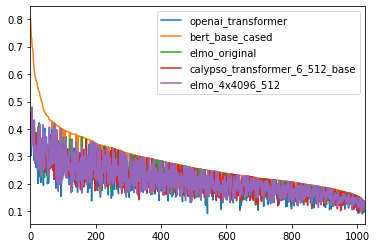

In [15]:
corr_df.plot()

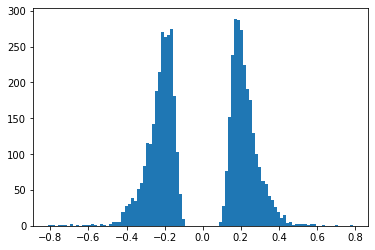

In [16]:
plt.hist(corr_ar.ravel(), bins=100)
plt.show()

### LinReg

In [17]:
method = "linreg"

In [18]:
corr_ar = np.stack([
    list(notated_neuron[1].values())
    for notated_neuron in res_d[method][network]
])
corr_df = pd.DataFrame(np.abs(corr_ar), columns=[basename(dirname(net)) for net in network_l if net != network])

In [19]:
corr_df.idxmin(axis=1).value_counts() # bad

openai_transformer    1024
dtype: int64

In [20]:
corr_df.idxmax(axis=1).value_counts() # bad, but doesn't affect rankings

bert_base_cased    1024
dtype: int64

In [21]:
# This is not a huge issue, these are remarkably similar
corr_df_pctl = pd.DataFrame()
corr_df_pctl["max"] = corr_df.max(axis=1)
corr_df_pctl["min"] = corr_df.min(axis=1)
corr_df_pctl["med"] = corr_df.median(axis=1)

corr_df_pctl.rank().corr() # spearman

,max,min,med
max,1.000000,0.966028,0.972692
min,0.966028,1.000000,0.979225
med,0.972692,0.979225,1.000000


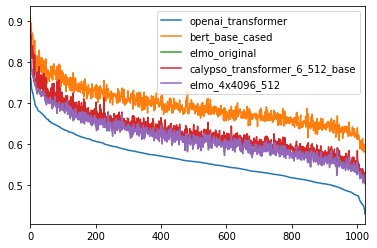

In [22]:
corr_df.plot()

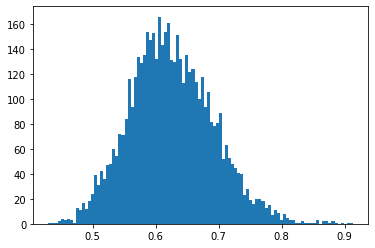

In [23]:
plt.hist(corr_ar.ravel(), bins=100)
plt.show()